# Project

## Introduction to the Project
The S&P 500 (Standard & Poor's 500) is a stock market index that tracks the performance of 500 of the largest publicly traded companies in the United States. It is widely regarded as one of the best representations of the U.S. stock market and economy. Over the long term, the S&P 500 has shown consistent growth, making it a key focus for long-term investors. However, it can also experience significant volatility in the short term.

In this project, we will make our first attempt to build a momentum-based strategy to trade the S&P 500 index. At the end of the project, you will have built a program that you can later expand and customise to suit your needs. We will use the python packages numpy, scipy and sqlite3, among others, in this project.

Tips: Review the code snippets that we went through during the course. Reorganize them and you are half-way done! Try experimenting with different configurations of the confidence interval, the lookback window and the forecast horizon. Be brave and experiment with different ways of deciding the position size. You may be surprised by your talent!

Re-organize your code from the exercises into a Python program that 
1. read prices from a database
2. calibrate a GBM model on each day when new prices are received.
3. forecast the price in e.g. 10 days and
   1. calculate the confidence interval of the forecast
   2. calculate the expected shortfall from the price forecast
4. code your trading signals using the price forecast and the expected shortfall.
5. store your postions into the *positions* table after each trade.
6. produce a 1-year backtest record from 2020-06-01 to 2021-05-31.

**Hint**

1. Collect all the code related to the GBM model into a class

In [42]:
# import libraries
import csv
import sqlite3
from contextlib import closing
from datetime import datetime

import numpy as np
from scipy.stats import norm

# craete a connection of database
conn = sqlite3.connect("SP500.db")
cs = conn.cursor()


In [43]:
class GBM:
    def __init__(self):
        self.mu, self.sigma = np.nan, np.nan
        self.rng = np.random.default_rng()
        
    def simulate(self, N, K, Dt, S0):
        sqrt_Dt = np.sqrt(Dt)
        traj = np.full((N+1, K), np.nan)
        drift = (self.mu - self.sigma**2/2) * np.linspace(1, N, N) * Dt
        for i in range(K):
            W = sqrt_Dt * np.cumsum(norm.rvs(size=N))
            traj[1:, i] = S0 * np.exp(drift + self.sigma * W)
            traj[0, i] = S0
        return traj

    def calibrate(self, trajectory, Dt):
        increments = np.diff(np.log(trajectory));
        moments = [0, 0];
        n_iter = 10;
        
        for iter in range(n_iter):
            X = self.rng.choice(increments, size=len(increments)//2)
            moments[0] += np.mean(X)/n_iter;
            moments[1] += np.mean(X**2)/n_iter
        
        std = np.sqrt(moments[1] - moments[0]**2);
        
        self.sigma = std/np.sqrt(Dt);
        self.mu = moments[0] / Dt + self.sigma**2/2;
        
    def forecast(self, latest, T, confidence):
        predicted = latest * np.exp(self.mu * T) 
        m = (self.mu - self.sigma**2/2)/2 * T;
        s = self.sigma * np.sqrt(T);
        Q = norm.ppf([(1-confidence)/2, (1+confidence)/2],  loc=m, scale=s)
        interval = latest * np.exp(Q)
        
        return {
            'confidence': confidence,
            'expected': predicted,
            'interval': interval
        }
        
    def expected_shortfall(self, T, confidence):
        mu = (self.mu - self.sigma**2/2)/2 * T;
        sigma = np.sqrt(T) * self.sigma;
        ES = -mu + sigma * norm.pdf(norm.ppf(confidence))/(1 - confidence);
        return ES;

In [44]:
# test your code here
model = GBM()
model.mu = 0.3
model.sigma = 0.2
simulated = model.simulate(500, 1, 1/250, 100)
simulated = simulated[:, 0]

model2 = GBM()
model2.calibrate(simulated, 1/250)

print(F"Calibrated: mu = {model2.mu}, sigma = {model2.sigma}")



Calibrated: mu = 0.08699720110897949, sigma = 0.1937485852928357


2. Write a function that prepares the database for trading, i.e.
   1. load the historical prices into the *prices* table
   2. create the *positions* table
   3. initialize the *positions* table with the your initial cash reserve. The initial *time_of_trade* can be any date before the earliest possible trading date.

    Call this function *prepare*.

In [45]:
# TODO make changes
# partially taken fron exercise 3
def prepare():
    
    # create prices table and insert values from the csv into it.
    # [TAKEN FROM EXERCISE 3]
    
    cs.execute("""
       create table if not exists prices (
       theday text primary key,
       price real
       );
    """)

    with closing(open('SP500.csv')) as fp:
        reader = csv.DictReader(fp, fieldnames=["date", "price"], delimiter="\t")
        for item in reader:
            cs.execute(F"""insert or ignore into prices values (\"{item['date']}\", {float(item['price'])})""")
    fp.close()

    # CREATE POSITION TABLE [TAKEN FROM EXERCISE 4]
    # STORE (date and time of trade, name of the instrument traded, 
    # quantity and amount of cash available.)
    cs.execute(F"""
        create table if not exists positions (
            time_of_trade text,
            instrument text,
            quantity real,
            cash real,
            primary key (time_of_trade, instrument)
            );
    """);

    # initialize position table
    cs.execute(F"""
    insert or ignore into positions values
    ('1666-01-01', 'SP500', 0, 1000000);
    """)
    conn.commit()

In [46]:
# check whether you have loaded the prices correctly
prepare()
latest_prices = cs.execute("select * from prices order by theday desc limit 10")
for item in latest_prices:
    print(item)

('2021-05-31', 4203.60009765625)
('2021-05-30', 4210.10009765625)
('2021-05-28', 4206.0)
('2021-05-27', 4217.10009765625)
('2021-05-26', 4196.0)
('2021-05-25', 4197.5)
('2021-05-24', 4204.7001953125)
('2021-05-23', 4153.2998046875)
('2021-05-21', 4161.39990234375)
('2021-05-20', 4165.5)


3. Write a function that determines the trade size, i.e. how many units of the instrument you would like to own when the date is *which_day* and the price forecast of the instrument is *forecast* and the expected shortfall from the same forecast is *ES*.

In [47]:
# [taken from exercise 4]
def position_size_v1(which_day, forecast, ES):
    cs.execute(F"""
    select quantity, cash from positions
    where instrument = 'SP500'
    and time_of_trade < '{which_day}'
    order by time_of_trade desc
    limit 1;
    """)
    qty, cash = cs.fetchall()[0]
    cs.execute(F"""
    select price from prices
    where theday <= '{which_day}'
    order by theday desc
    limit 1;
    """);
    price = cs.fetchall()[0][0]
    capital = cash + qty * price
    if price < forecast['interval'][0]:
        return round(capital/price)
    elif price > forecast['interval'][1]:
        return -round(capital/price)
    else:
        return 0


# risk appetite based on expected shortfall
# [taken from exercise 4]
def position_size_v2(which_day, forecast, ES):
    cs.execute(F"""
    select quantity, cash from positions
    where instrument = 'SP500'
    and time_of_trade < '{which_day}'
    order by time_of_trade desc
    limit 1;
    """)
    qty, cash = cs.fetchall()[0]
    cs.execute(F"""
    select price from prices
    where theday <= '{which_day}'
    order by theday desc
    limit 1;
    """);
    price = cs.fetchall()[0][0]
    capital = cash + qty * price
    exposure = capital * 0.05/ES
    if price < forecast['interval'][0]:
        return round(exposure/price)
    elif price > forecast['interval'][1]:
        return -round(exposure/price)
    else:
        return 0

4. Write a function that, for a given date, calibrates a GBM model to the data prior to that date and that forecasts the price in 10 days. Call this function *analyse*.

In [48]:
# TODO finalized
def analyse(which_day):
    cs.execute(F"""
    select price from prices where theday <= '{which_day}'
    order by theday desc limit 120;
    """)
    P = np.flipud(np.asarray(cs.fetchall())).flatten();
    model = GBM();
    Dt = 1.0/252;
    model.calibrate(P, Dt);
    T = 10 * Dt;
    confidence = 0.1
    forecast = model.forecast(P[-1], T, confidence);
    ES = model.expected_shortfall(T, 0.95)
    
    # return position_size_v1(which_day, forecast, ES);
    return position_size_v2(which_day, forecast, ES);


In [49]:
# Test the analyse function
test_dates = ['2021-05-09', '2021-05-14']
positions = [np.nan, np.nan]
for i in range(2):
    positions[i] = analyse(test_dates[i])
    print(F"{positions[i]} shares advised on {test_dates[i]}.")

289 shares advised on 2021-05-09.
257 shares advised on 2021-05-14.


5. The main loop of the program: Loop over the dates in the backtest period and use the *analyse* function to decide what to do on each day. Call this function *main*.

In [50]:
def main(begin_on):
    cs.execute(F"select theday from prices where theday >= '{begin_on}';")
    days = [d[0] for d in cs.fetchall()]
    asset = {
        'old': np.nan,
        'new': np.nan
    };
    cash = {
        'old': np.nan,
        'new': np.nan
    };
    cs.execute("delete from positions where time_of_trade > '2020-01-01';");
    for d in days:
        asset['new'] = analyse(d)
        cs.execute(F"""
        select quantity, cash from positions
        where time_of_trade < '{d}'
        order by time_of_trade desc
        limit 1;
        """);
        asset['old'], cash['old'] = cs.fetchall()[0];
        cs.execute(F"""
        select price from prices
        where theday <= '{d}'
        order by theday desc
        limit 1;
        """);
        latest = cs.fetchall()[0][0]
        trade_size = round(asset['new']) - round(asset['old']);
        if trade_size != 0:
            cash['new'] = cash['old'] - trade_size * latest;
            cs.execute(F"""
            insert into positions values
            ('{d}', 'SP500', {round(asset['new'])}, {cash['new']});
            """);
        conn.commit();



6. Connect to the database and create a *cursor* object associated with the connection. Share the connection and the cursor object across the program so that you don't have to connect to and disconnect from the database in every function of the program.

In [51]:
if __name__ == "__main__":
    with closing(sqlite3.connect("SP500.db")) as conn:
        with closing(conn.cursor()) as cs:
            prepare()
            main('2020-06-01')
    


In [52]:
# plot your track record
conn = sqlite3.connect("SP500.db")
cs = conn.cursor()

day1 = '2020-06-01'
day1_dt = datetime.strptime(day1, '%Y-%m-%d')

cs.execute(f"""
    select theday, quantity * price + cash as wealth
    from positions as PO
    join prices as PR
    on PO.time_of_trade = (
        select time_of_trade from positions
        where time_of_trade <= PR.theday
        order by time_of_trade desc limit 1
    )
    where theday >= '{day1}';
""")

records = cs.fetchall()

def calculate_T(record, day1_dt):
    theday, wealth = record
    theday_dt = datetime.strptime(theday, '%Y-%m-%d')
    T = (theday_dt - day1_dt).days
    return (T, wealth)

records = [calculate_T(record, day1_dt) for record in records]
W = np.asarray(records)

In [53]:
import matplotlib.pyplot as plt

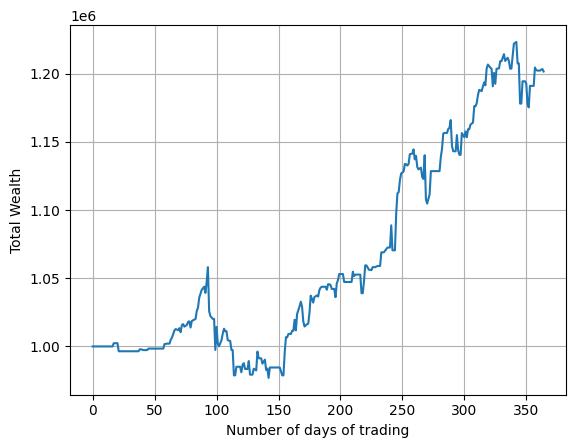

In [54]:
fig = plt.plot(W[:,0], W[:, 1])
plt.grid()
plt.xlabel("Number of days of trading")
plt.ylabel('Total Wealth');